# PHYS 6260: Homework 3, C. Michael Haynes

In [1]:
# generic list of import statements to not have to keep track
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import constants
import math as m
import warnings
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings( "ignore")

## Problem 1
### Laplace's equation: 2-D Model of an Electronic Capacitor

We use the relaxation (Jacobi) method to solve Laplace's equation for the capacitor specified. This takes advantage of the laplace operator's "averaging" nature, using the surrounding grid points to update each one. This method does NOT correspond to time evolution (unless it is perscribed through the boundary values, similar to problem 2); rather, the iterations are converging towards a steady-state "snapshot" of the capacitor at a single instant in time (or, when it is fully charged with a steady voltage and the potential field does not change).

The Jacobi method relates the potential $\phi$ at a point $(x,y)$ to the average of its neighbors, i.e.:
$$ \phi(x,y) = \frac{1}{4} \left [ \phi(x + \epsilon,y) + \phi(x - \epsilon,y) + \phi(x, y+ \epsilon) + \phi(x, y - \epsilon) \right ] $$
for a grid spacing $\epsilon$. We take advantage of this method and the routine learned in class to calculate the solution to Laplace's equation (or Poisson's equation in a charge-free environment):
$$ \nabla^2 \phi = 0$$

In [21]:
# Define parameters
V = 1.0         # Voltage for capacitor plates (+/-)
target = 1.e-06   # requested precision of 1 uV
M = 100         # Grid side number of points
L = 10.         # side length in centimeters
dl = L/M        # grid spacing in centimeters

# Create arrays to hold potential values, as done in class: [x_idx, y_idx]
phi = np.zeros([M+1,M+1],float)
phiprime = np.empty([M+1,M+1],float)

# calculate indices for array slicing to enforce Voltage values
pV_Xidx = int(2./dl)
nV_Xidx = int(8./dl)
# pV_Yidx = nV_Yidx = pV_Xidx:nV_Xidx

# set positive plate
phi[pV_Xidx,pV_Xidx:nV_Xidx] = V
# set negative plate
phi[nV_Xidx,pV_Xidx:nV_Xidx] = -V


delta = 1.0
iteration = 0
while delta>target:

    # Calculate new values of the potential
    phiprime[0,:] = phi[0,:]
    phiprime[-1,:] = phi[-1,:]
    phiprime[:,0] = phi[:,0]
    phiprime[:,-1] = phi[:,-1]
    
    phiprime[1:M,1:M] = (1./4.) * (phi[2:,1:M] + phi[:M-1,1:M] + phi[1:M,2:] + phi[1:M,:M-1])

    # enforce voltages on the plates
    phiprime[nV_Xidx,pV_Xidx:nV_Xidx] = phi[nV_Xidx,pV_Xidx:nV_Xidx]
    phiprime[pV_Xidx,pV_Xidx:nV_Xidx] = phi[pV_Xidx,pV_Xidx:nV_Xidx]
    
#    for i in range(M+1):
#        for j in range(M+1):
#            if i==0 or i==M or j==0 or j==M:
#                phiprime[i,j] = phi[i,j]
#            else:
#                phiprime[i,j] = 0.25*(phi[i+1,j] + phi[i-1,j] \
#                                      + phi[i,j+1] + phi[i,j-1])

    # Calculate maximum difference from old values
    delta = np.max(abs(phi-phiprime))
    if iteration % 100 == 0:
        print("Iteration %3d: max. residual = %12.6g" % (iteration, delta))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi
    iteration += 1

# transpose the solution to obtain proper coordinates associated with the arrangement of the phi, phiprime arrays
phi = phi.T

Iteration   0: max. residual =         0.25
Iteration 100: max. residual =   0.00239703
Iteration 200: max. residual =   0.00120217
Iteration 300: max. residual =  0.000793906
Iteration 400: max. residual =   0.00057422
Iteration 500: max. residual =   0.00042632
Iteration 600: max. residual =   0.00031856
Iteration 700: max. residual =  0.000238398
Iteration 800: max. residual =  0.000178556
Iteration 900: max. residual =  0.000133849
Iteration 1000: max. residual =   0.00010037
Iteration 1100: max. residual =  7.52813e-05
Iteration 1200: max. residual =  5.64678e-05
Iteration 1300: max. residual =  4.23548e-05
Iteration 1400: max. residual =  3.17658e-05
Iteration 1500: max. residual =  2.38205e-05
Iteration 1600: max. residual =  1.78593e-05
Iteration 1700: max. residual =  1.33873e-05
Iteration 1800: max. residual =  1.00331e-05
Iteration 1900: max. residual =  7.51794e-06
Iteration 2000: max. residual =  5.63225e-06
Iteration 2100: max. residual =  4.21885e-06
Iteration 2200: max.

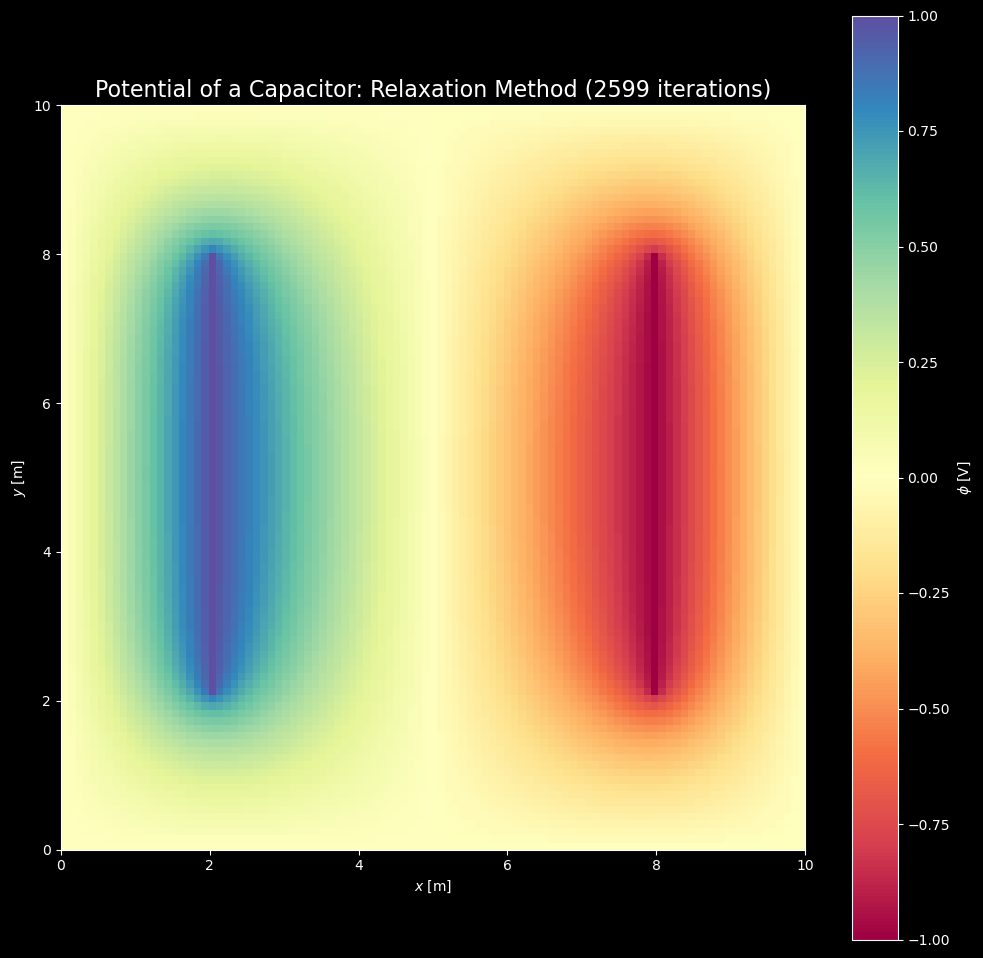

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
f1 = ax.imshow(phi, extent=[0,10,0,10], cmap='Spectral')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
fig.colorbar(f1,label=r'$\phi$ [V]')
plt.title('Potential of a Capacitor: Relaxation Method ('+str(iteration)+' iterations)',fontsize=16)
plt.show()

## Problem 2
### Heat equation: Thermal diffusion in Earth’s crust
We wish to calculate the temperature profile as a function of depth in Earth's crust and time over the course of many years. To do so, we implement a numerical tool to calculate a solution for the Heat (diffusion) equation on a prescribed grid mesh. 

Using a time-variable boundary condition for the terrestrial surface temperature, we can emulate the the temperature due to variablility in solar radiation over a point on Earth's surface throughout its orbit. The functional form of the time-dependent boundary value is given by 
$$ T_0(t) = A + B\sin{\left(\frac{2\pi t}{\tau}\right)} \qquad , $$
where $A=10^\circ$ C, $B=12^\circ$, and $\tau=365 \,\mathrm{d}$. We treat the Earth's crust to have a roughly constant thermal diffusivity $D=0.1\,\mathrm{m}^2\,\mathrm{d}^{-1}$. At a depth of $20\,\mathrm{m}$ below the surface, the temperature is approximately constant as a function of time due to the internal heat generated in Earth's core and transported outward by the mantle. Thus, we have two Dirichlet boundary conditions (i.e., perscribed values) at either end of the spatial domain, and the time variability is encoded via our time-dependent boundary condition. We initialize the spatial domain with a constant temperature of $10^\circ $ everywhere inside of the boundaries.

In [2]:

tau = 365   # days / year
eta = 0.1   # m^2 / day

## Modulating Parameters ##
A = 10.     # deg Celsius
B = 12.     # deg Celsius
BC_inner = 11.  # deg Celsius
dz = 0.1    # meters
#############################

## calculate timestep to fulfill stability condition, namely     (eta * dt / dx^2) < 1/2
# Set this parameter to choose the threshold below stability to modulate timestep,  **ranges (1,infty)**
# effectively the factor by which dt would need to be multiplied to make the stability condition equation an equality
timestep_threshold = 1.01
# calculate timestep
dt = (dz ** 2)/(2.*eta)
dt /= timestep_threshold
## this gives timestep in DAYS
print("\n\nTimestep in days: "+str(round(dt,5))+"\n")
# convert to years
dt /= tau

## compute D
D_coef = (eta*dt*tau) / (dz ** 2)

## initialize coordinates
depth_arr = np.arange(start=0,stop=20.,step=dz)
num_spatial_steps = len(depth_arr)
time_arr = np.arange(start=0.,stop=10.,step=dt)
num_timesteps = len(time_arr)


## Time dependent surface boundary condition
def BC_t(t):
    return (A + B*np.sin((2*m.pi)*t))

## initialize IC
depth_IC = np.full(num_spatial_steps,10.)   # set all values to 10 deg Celsius
depth_IC[0] = BC_t(0.)
depth_IC[-1]= 11.

Temp_profile = depth_IC.copy()
newTemp_profile = np.zeros(num_spatial_steps)
timeDependent_Temp_profile = [Temp_profile.copy()]

## START SOLVER
for n in range(num_timesteps):
    for j in range(num_spatial_steps):
        if j == 0:
            newTemp_profile[j] = BC_t(n*dt)
        elif j == num_spatial_steps-1 :
            newTemp_profile[j] = BC_inner
        else:
            newTemp_profile[j] = Temp_profile[j] + D_coef*(Temp_profile[j+1] - 2*Temp_profile[j] + Temp_profile[j-1])
        

    timeDependent_Temp_profile.append(newTemp_profile.copy())
    Temp_profile = newTemp_profile.copy()

## plotting and visualization

dt_per_year = 1 // dt
dt_inc = dt_per_year // 4

#print(dt_per_year)



Timestep in days: 0.0495



Here we plot the specified quantities: for final (10th) year, we plot four temperature profiles taken at 3-month intervals on a single graph to illustrate how the temperature behaves as a function of depth and time. Additionally, we include a colormap displaying the temperature evolution. 

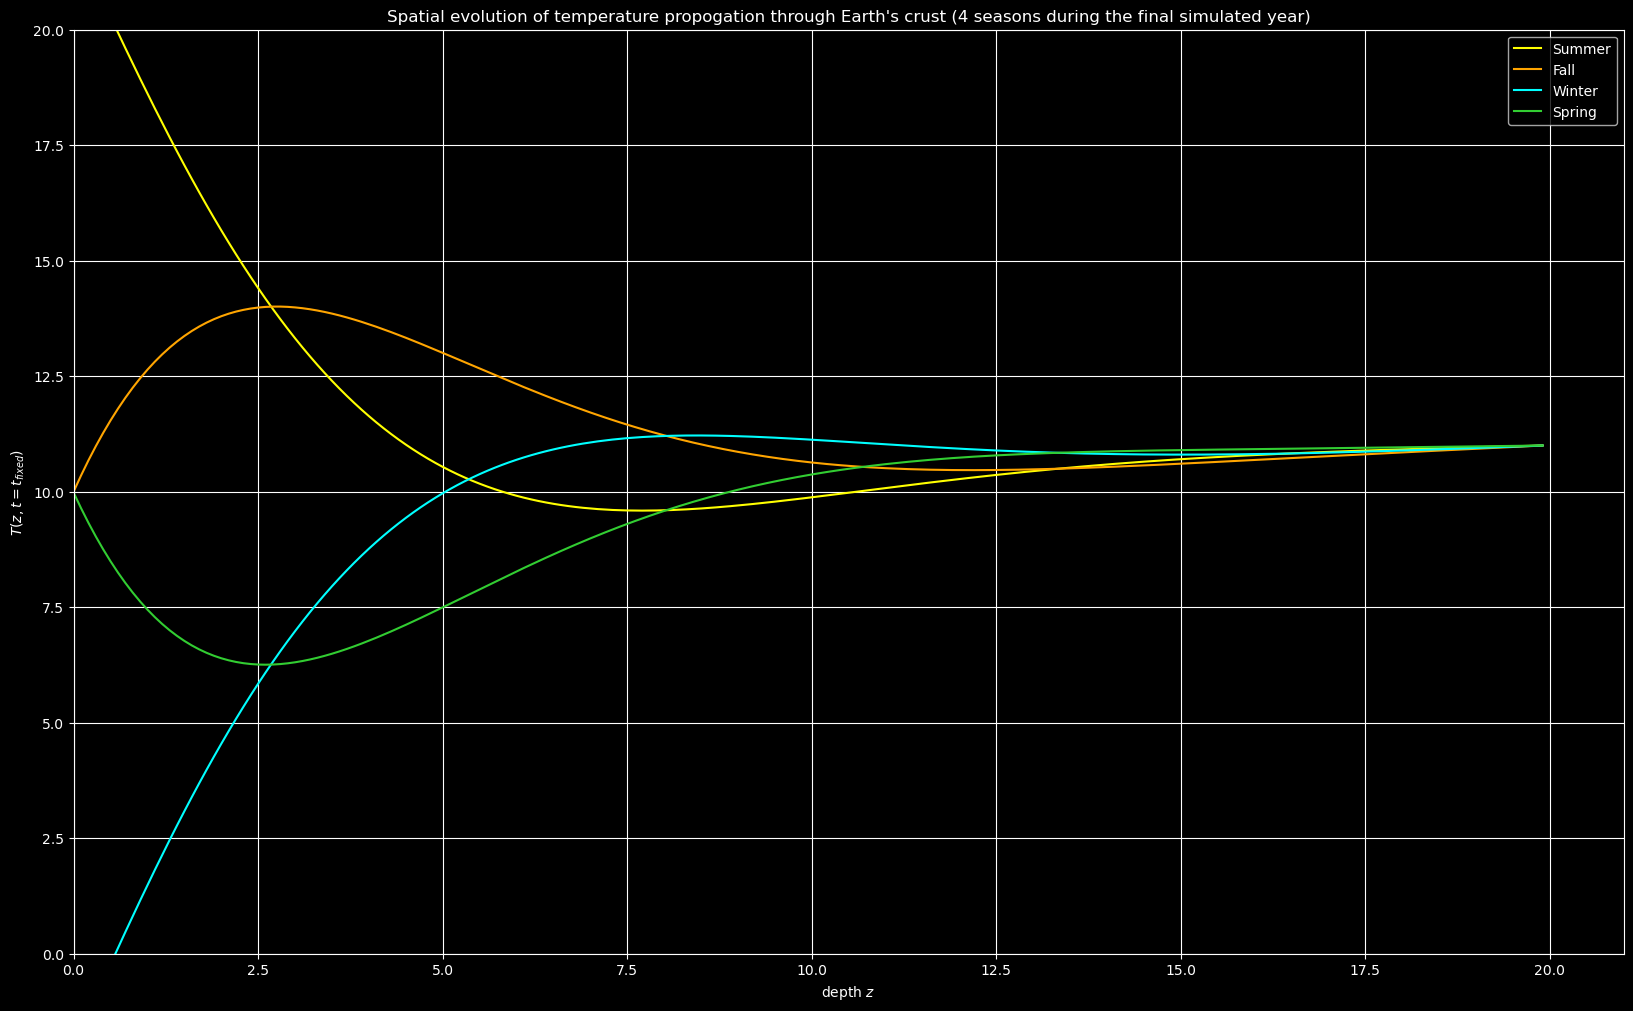

In [3]:
plt.style.use('dark_background')


plot_1 = timeDependent_Temp_profile[num_timesteps-1][:]
plot_2 = timeDependent_Temp_profile[int(num_timesteps-dt_inc)][:]
plot_3 = timeDependent_Temp_profile[int(num_timesteps-(2*dt_inc))][:]
plot_4 = timeDependent_Temp_profile[int(num_timesteps-(3*dt_inc))][:]




x_grid = np.arange(start=0,stop=20.1,step=dz)

## plot of solution
fig, ax = plt.subplots(figsize=(20,12))

plt.plot(depth_arr, plot_4,label='Summer',color='yellow')
plt.plot(depth_arr, plot_3,label='Fall', color='orange')
plt.plot(depth_arr, plot_2,label='Winter',color='cyan')
plt.plot(depth_arr, plot_1,label='Spring',color='limegreen')


plt.xlim(0,21)
plt.ylim(0,20)

plt.legend()
plt.grid()
plt.xlabel("depth $z$")
plt.ylabel("$T(z,t=t_{fixed})$")
plt.title("Spatial evolution of temperature propogation through Earth's crust (4 seasons during the final simulated year)")
plt.show()

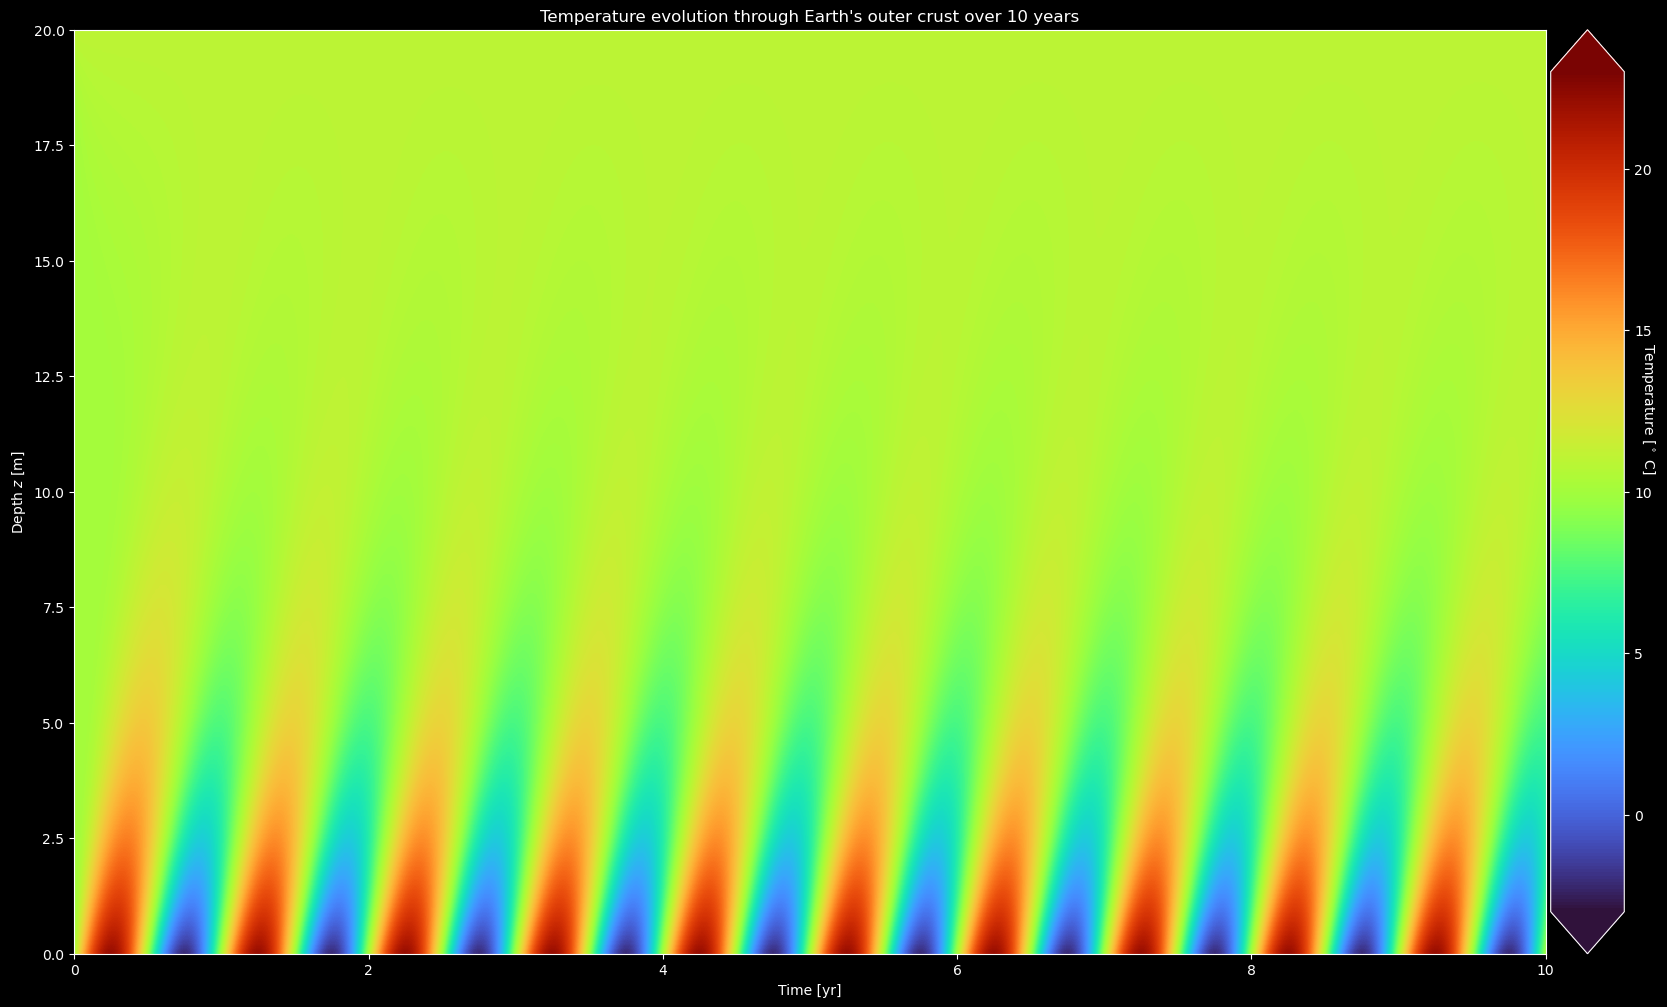

In [4]:
plt.figure(figsize=(20,12))
ax = plt.gca()

#fig1 = plt.imshow(timeDependent_Temp_profile, extent = [0,360, -90,90], origin = 'lower', cmap = 'viridis',interpolation='catrom', vmin = 0, vmax = maxel+1e2)
fig1 = plt.imshow(np.transpose(timeDependent_Temp_profile), origin = 'lower', cmap = 'turbo', vmin = -3, vmax = 23, aspect = 'auto', extent=[0,10,0, 20])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('Time [yr]')

ax.set_title('Temperature evolution through Earth\'s outer crust over 10 years')
cbar = plt.colorbar(fig1,cax = cax, extend='both')
cbar.set_label('Temperature [$^\circ$ C]',y=0.6,rotation=270)
plt.show()

## Problem 3
### Wave equation 

#### (a) FTCS (Forward-time, Centered-spatial) Integration method: solving the wave equation

#### (b) FTCS (Forward-time, Centered-spatial) Integration method: Numerical Stability

## Problem 4
### Application question: